In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
# from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
fetching from athenadb...
loading from ../../misc/cache/dataframes_ts_12102020_athena.pkl
104 183
Smoothing 6191 recovered between 2020-05-28 and 2020-04-11 (47) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-11 (64) days in a weighted-mag manner
Smoothing 917 deceased between 2020-06-15 and 2020-04-11 (65) days in a weighted-mag manner
Smoothing 2434 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5903 recovered between 2020-07-01 and 2020-05-28 (34) days in a weighted-mag manner

splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 170                 | 171                 | 172                 | 173                 | 174                 |
|-------------+----------

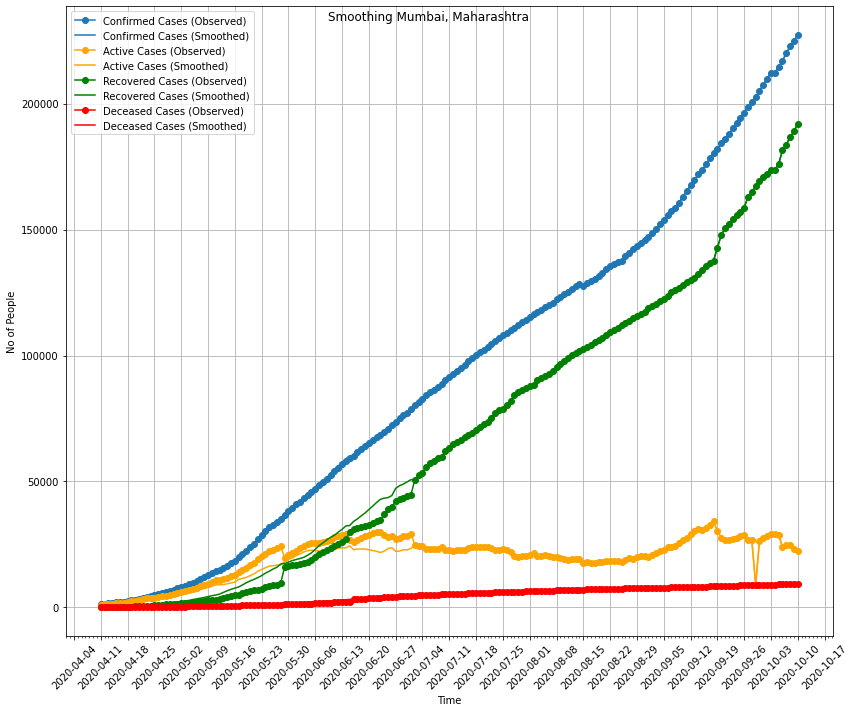

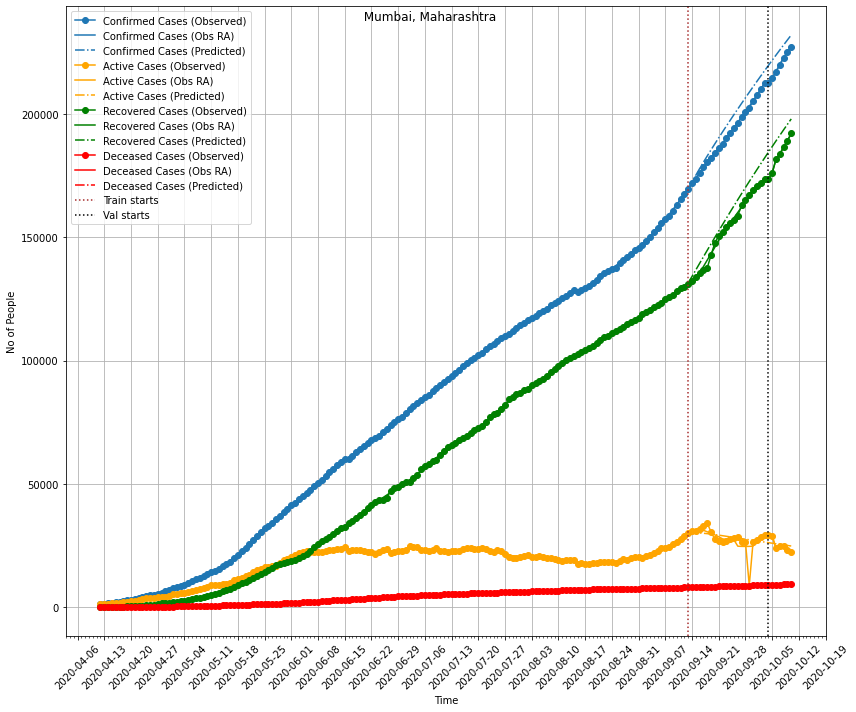

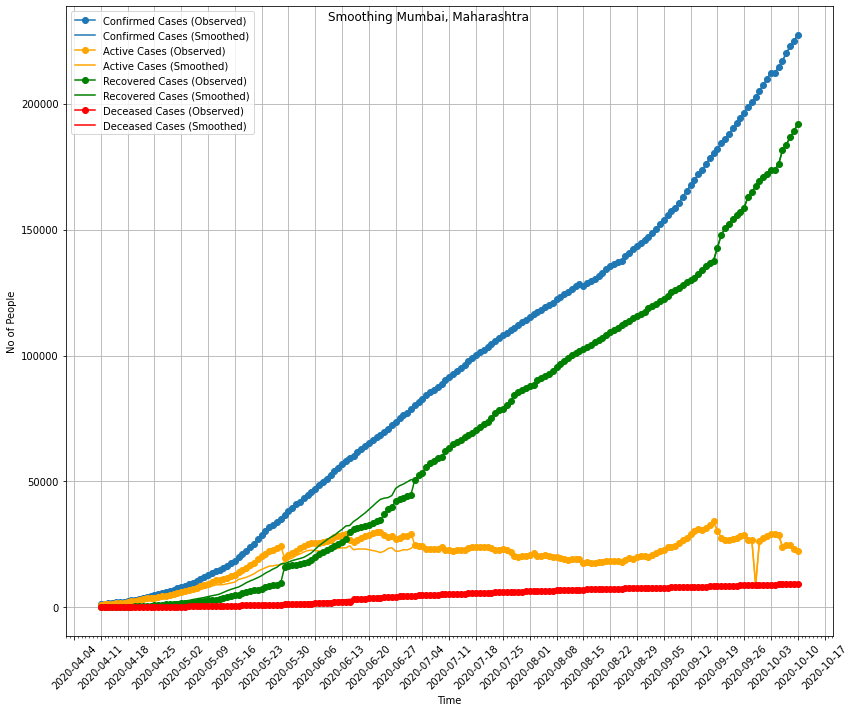

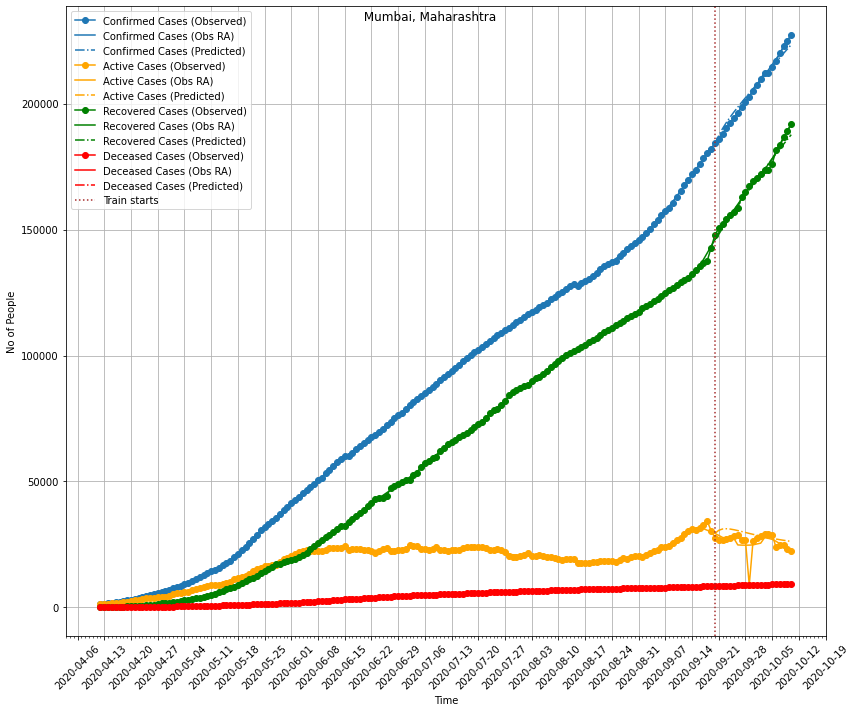

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.28299749929356566,
 'I_hosp_ratio': 0.4041230381080484,
 'P_fatal': 0.01440481606843338,
 'T_inc': 4.310660566209386,
 'T_inf': 3.740344569124589,
 'T_recov': 11.169432943834494,
 'T_recov_fatal': 11.385691364161996,
 'lockdown_R0': 0.9485457194051801}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.010963385414099552,
 'I_hosp_ratio': 0.4908131119588425,
 'P_fatal': 0.03343092487564302,
 'T_inc': 4.403039359158847,
 'T_inf': 3.6861223919729382,
 'T_recov': 13.306239718030952,
 'T_recov_fatal': 22.7489186281096,
 'lockdown_R0': 0.9980308545577887}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

train      val
total       2.07589  2.71918
active       14.791  7.56785
recovered   2.97664  4.38692
deceased   0.946855  2.38641

### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

train
total      0.794462
active      20.3243
recovered  0.933779
deceased   0.591999

## Sensitivity Plot

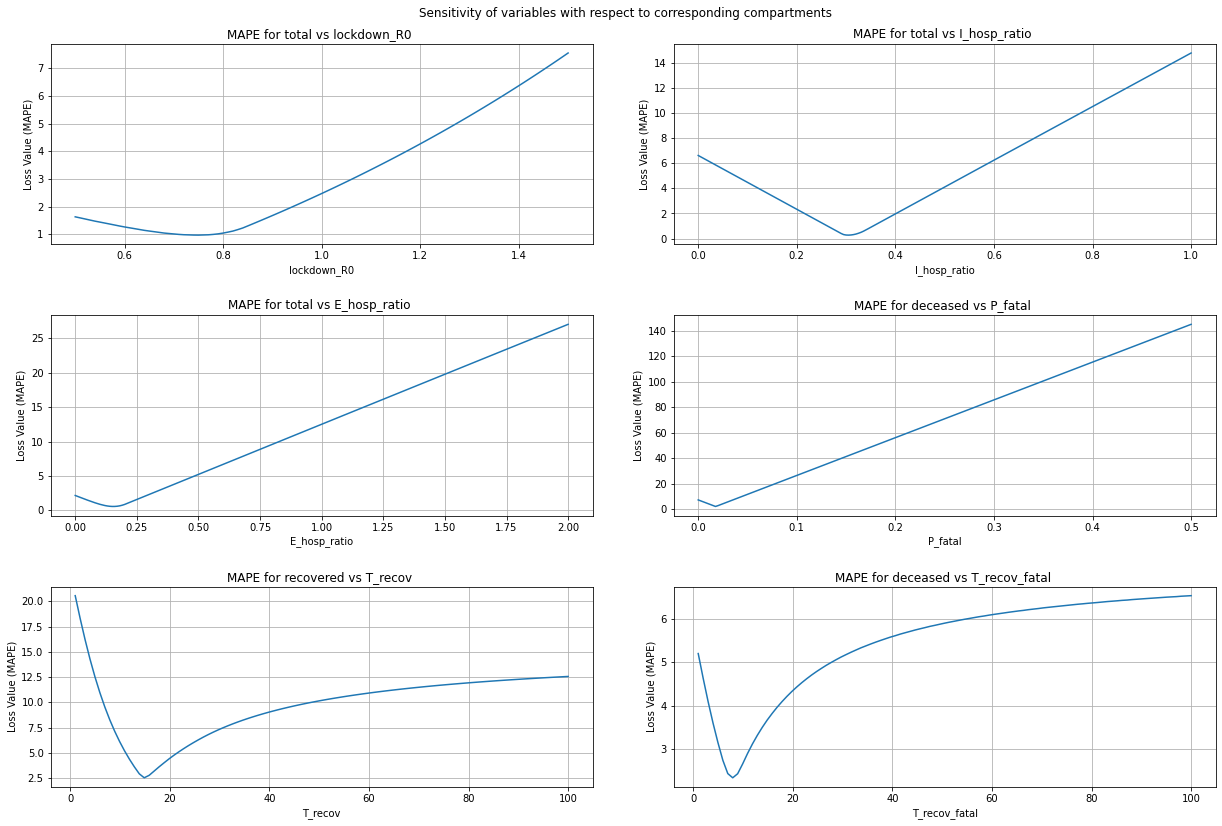

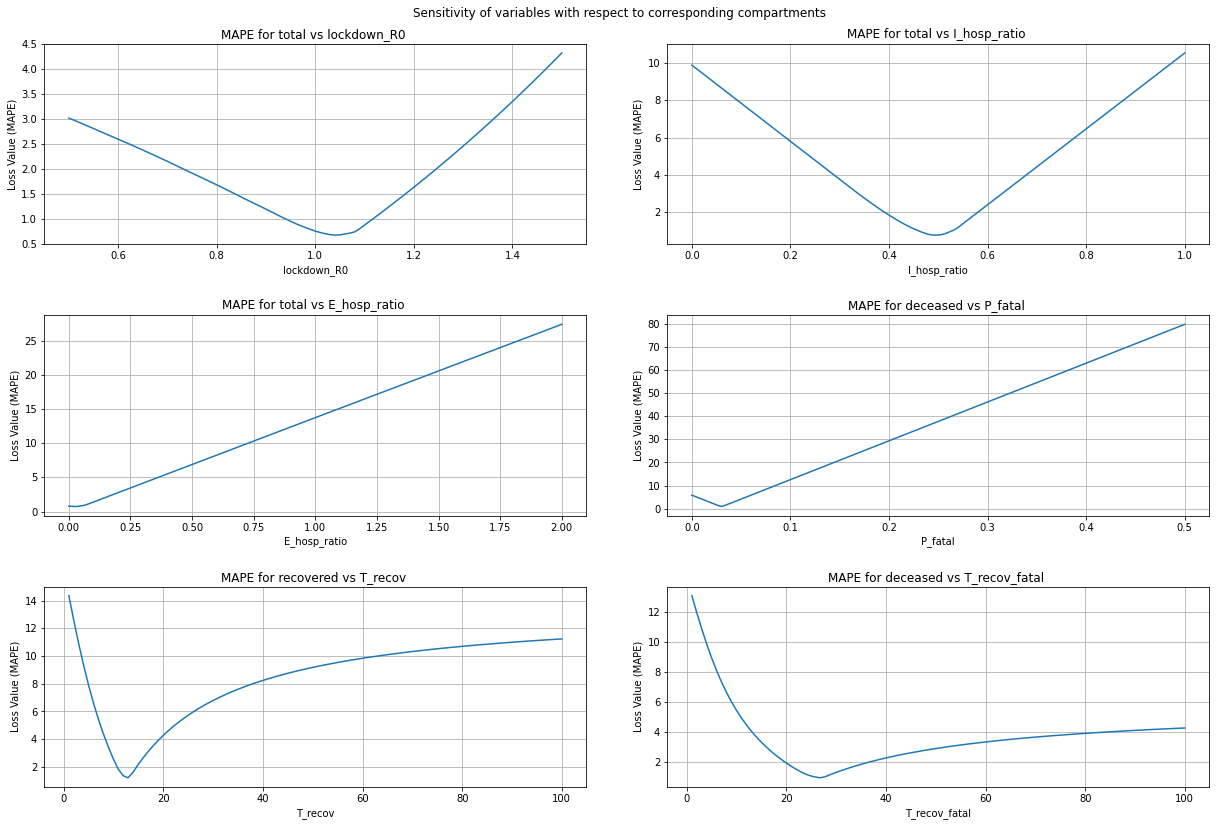

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

getting forecasts ..
12it [00:00, 118.62it/s]getting forecasts ..
100it [00:00, 119.62it/s]
11it [00:00, 102.45it/s]getting forecasts ..
100it [00:00, 112.90it/s]


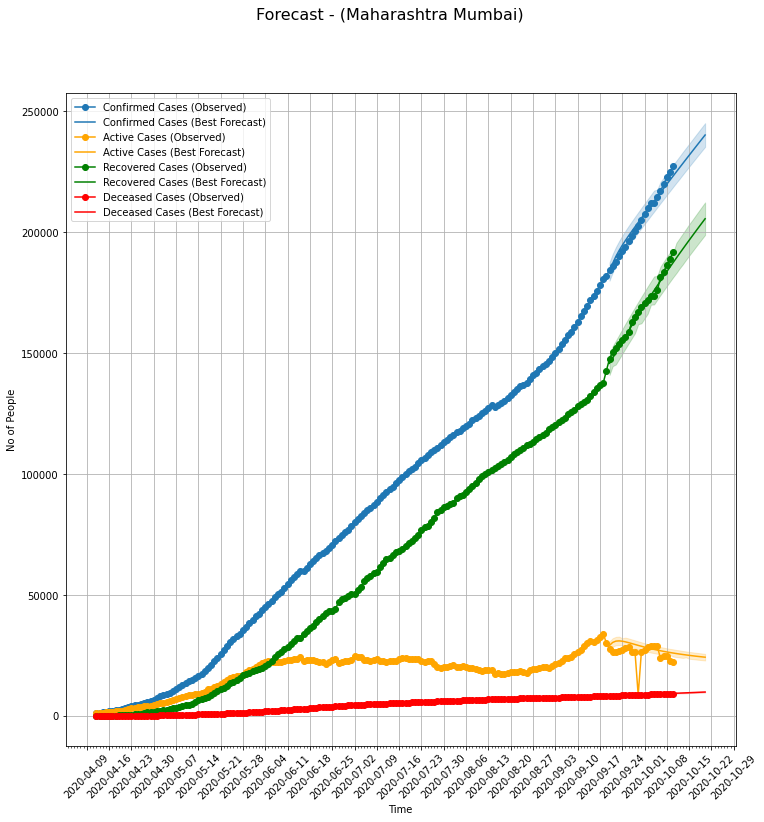

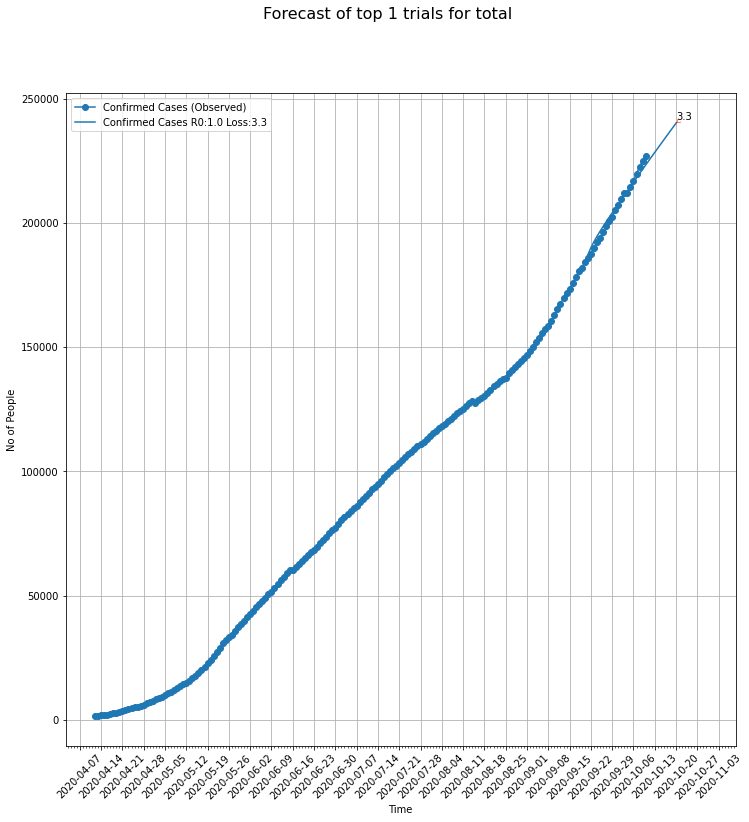

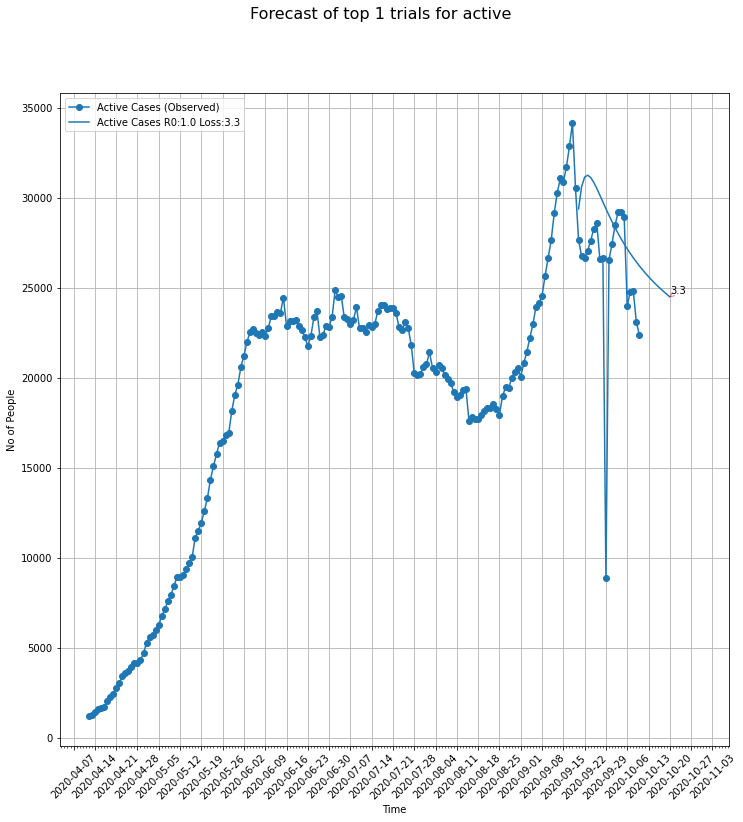

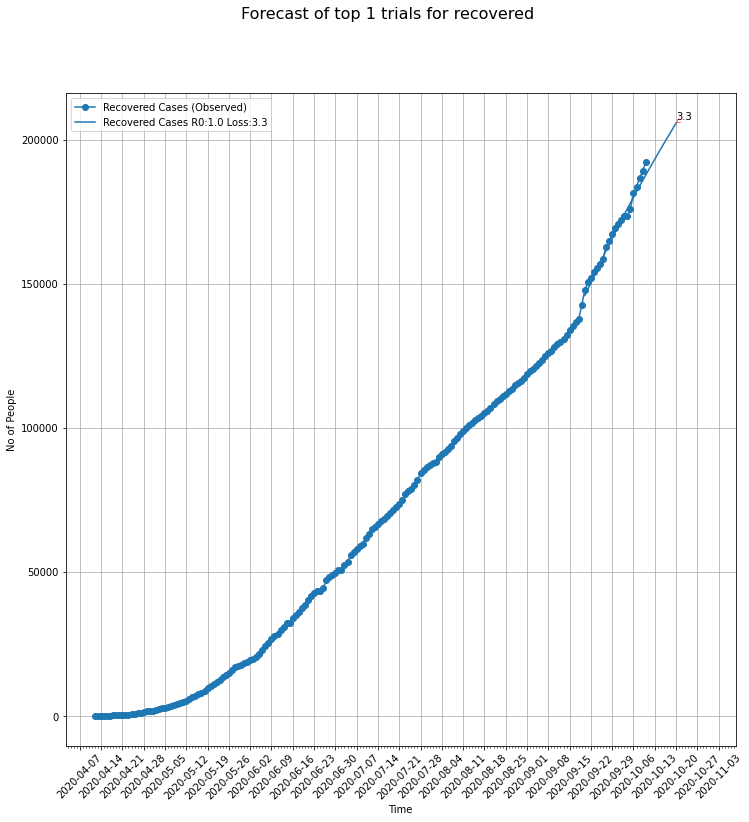

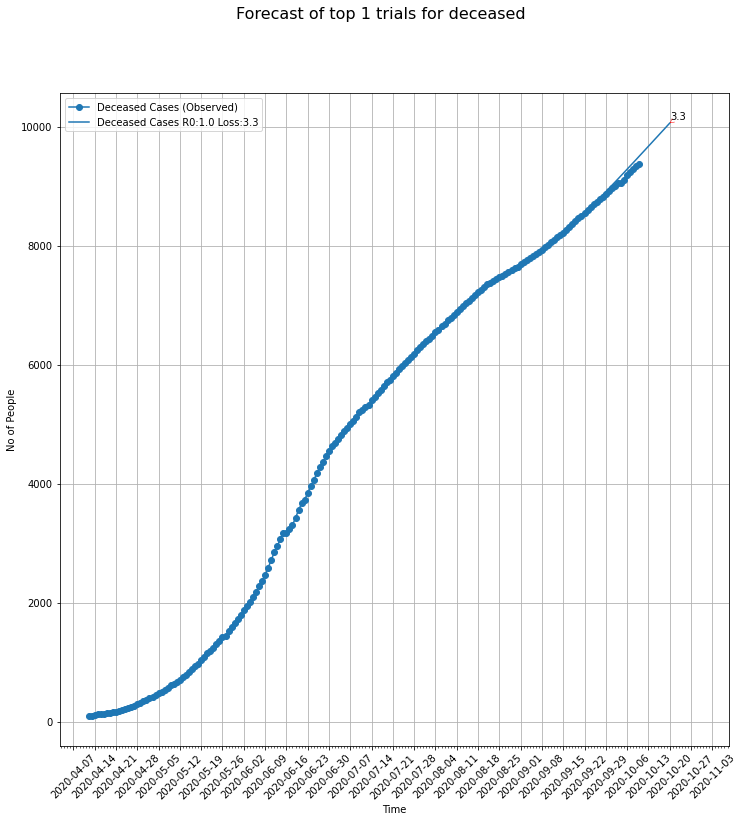

In [12]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [13]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:06<00:00, 16.60trial/s, best loss: 3.4517775143715763]


In [14]:
uncertainty.beta_loss

{'active': 9.46526057971125,
 'recovered': 2.444512726939307,
 'deceased': 0.2780043692925031,
 'total': 1.6193323815432454}

In [15]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [16]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

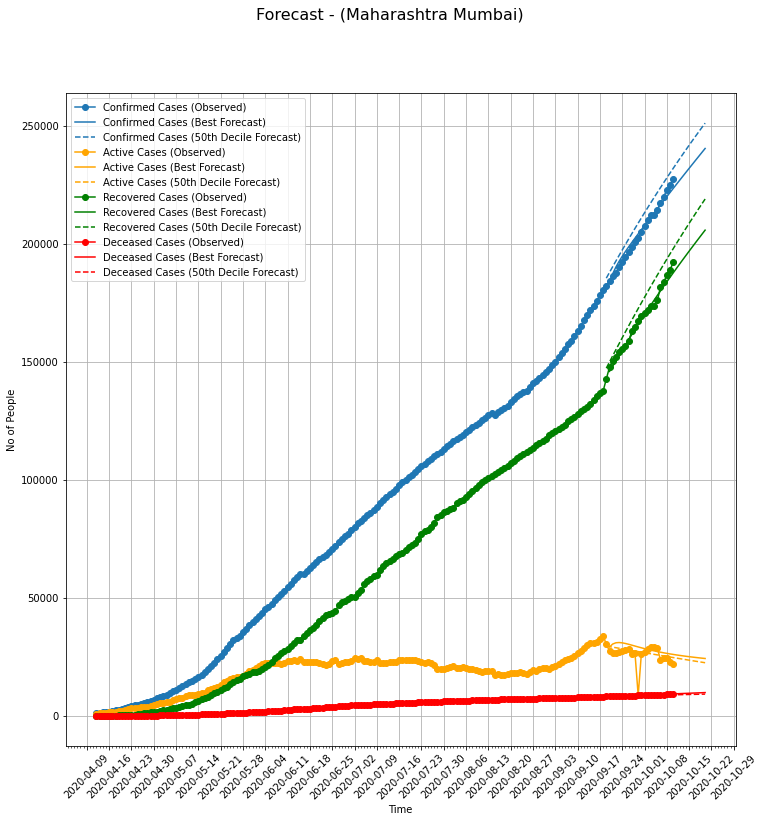

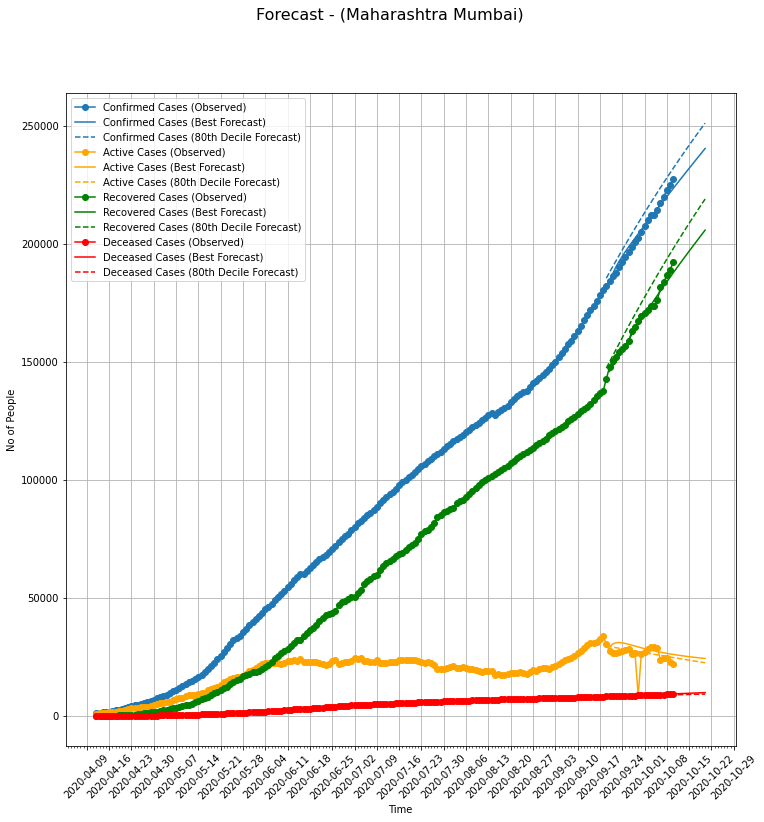

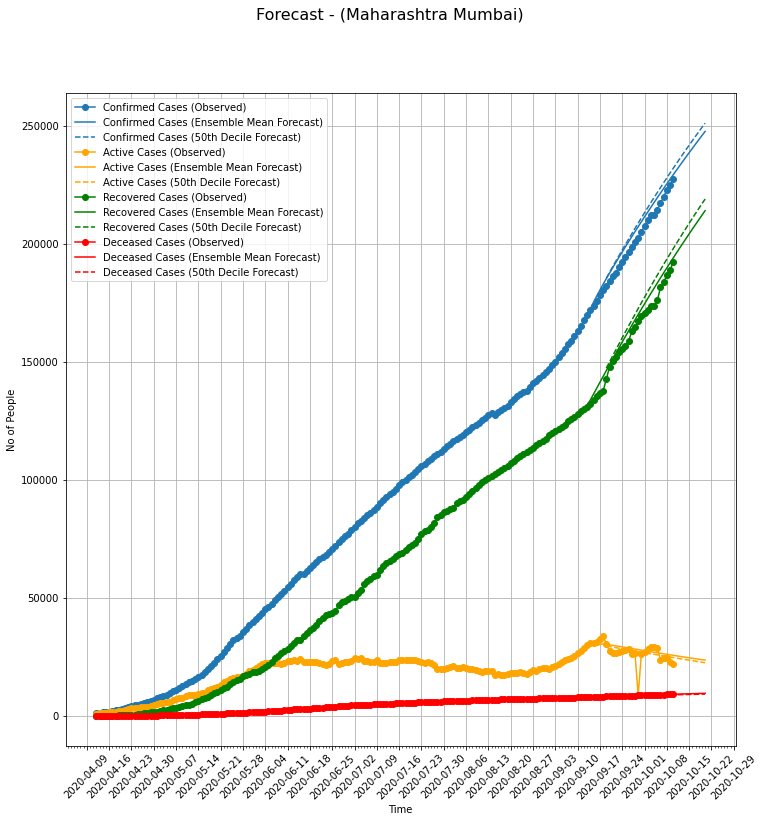

In [17]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

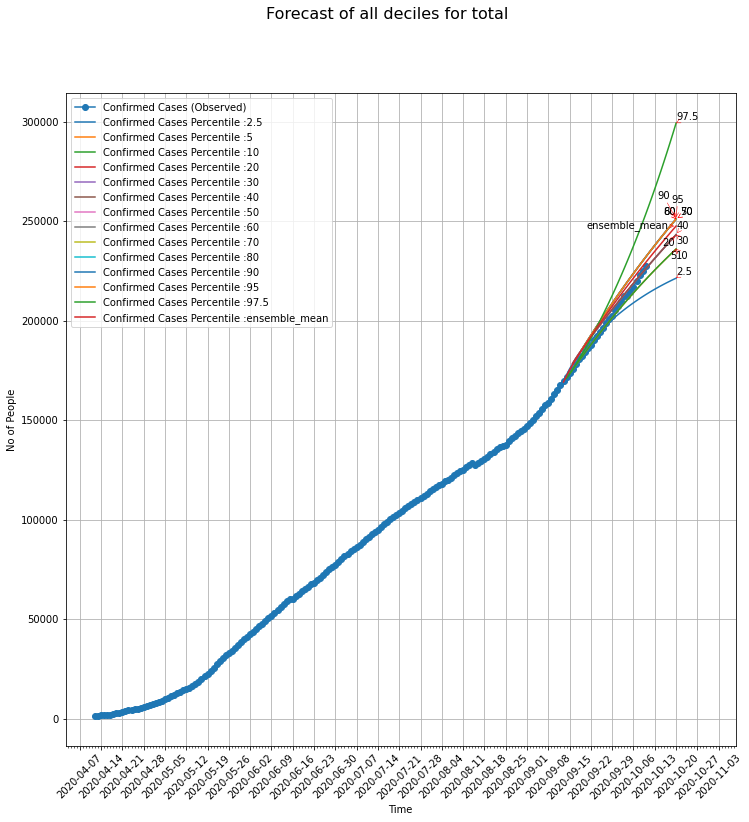

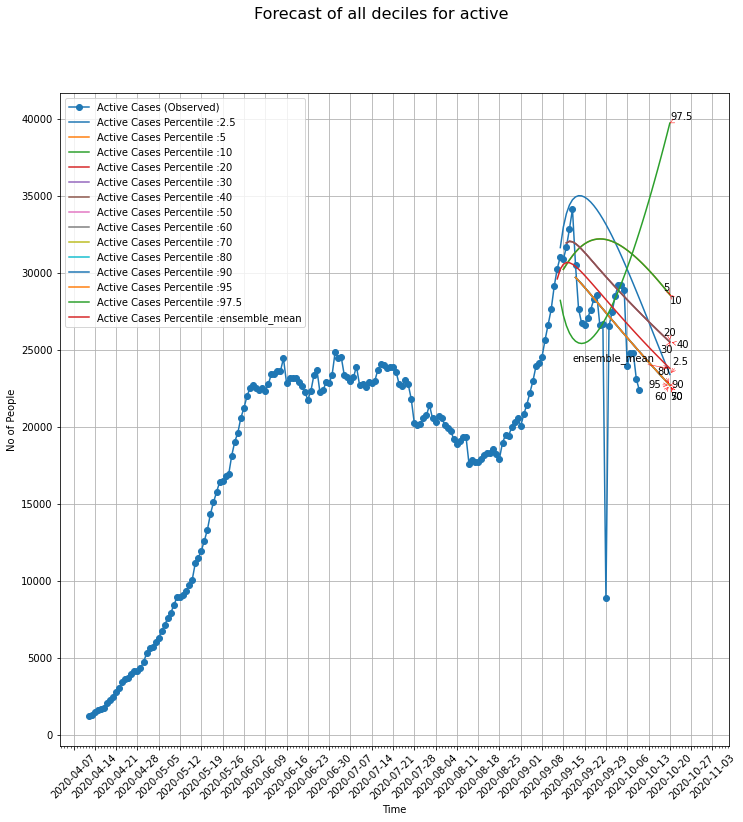

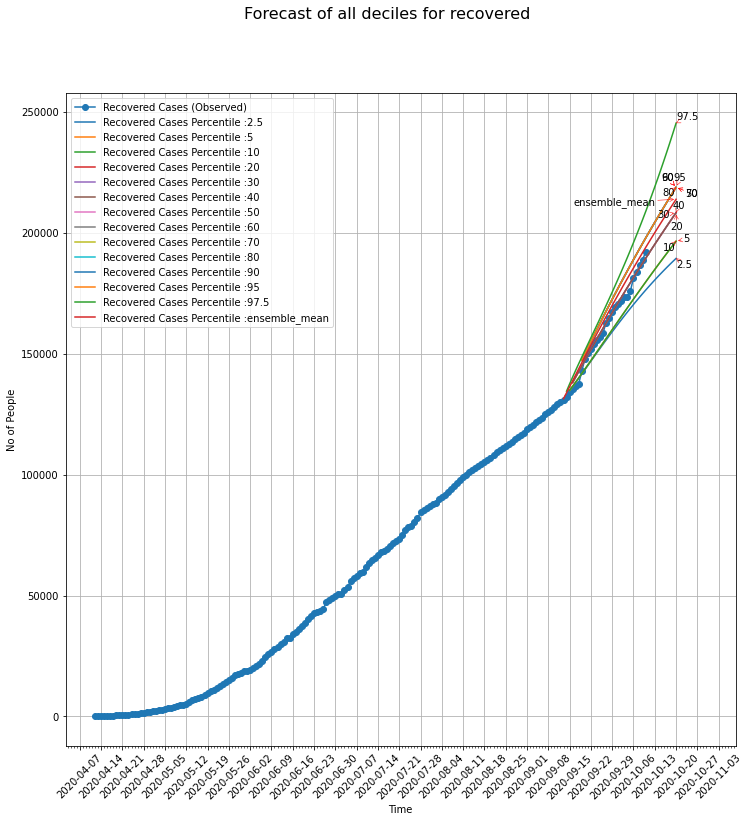

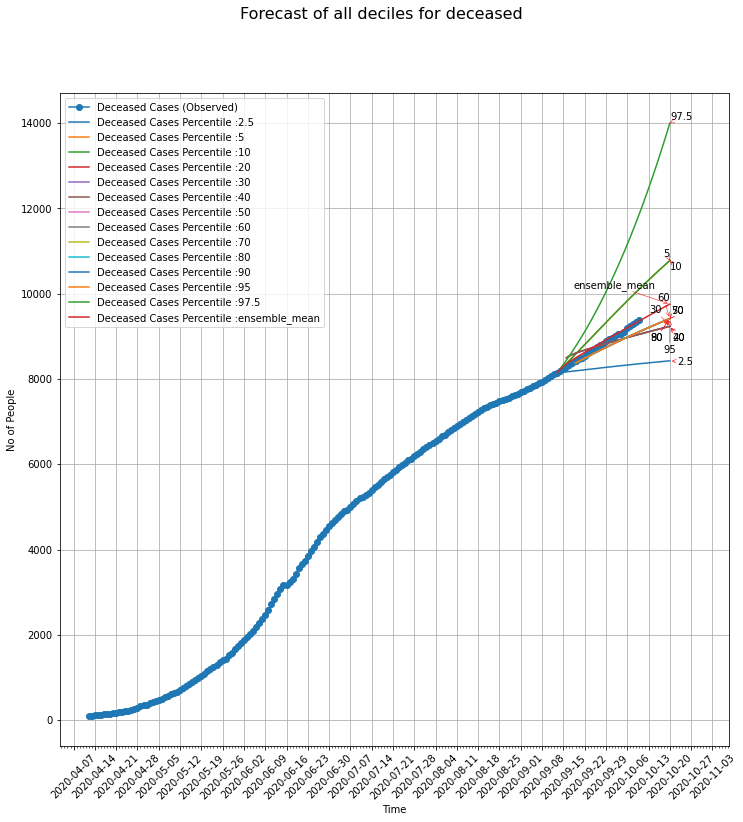

In [18]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [19]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [20]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [21]:
# log_wandb(predictions_dict)

## Create All Trials Output

In [22]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

In [ ]:
predictions_dict['m1']['df_district'].to_csv('mumbai_official.csv')